In [3]:
import numpy as np
import matplotlib.pyplot as plt
import graphlearning as gl
from scipy.optimize import minimize, LinearConstraint
import sklearn.datasets as datasets


Generate a sample of size 2 * n containing n data points from each class.
All data points are sampled from a dim-dimensional Gaussian.

[[3.1 3.6]
 [1.6 3.2]
 [2.6 2.4]
 [3.2 3.5]
 [3.7 2. ]
 [2.5 3.2]
 [2.7 1.4]
 [4.4 1.1]]
[0. 0. 0. 0. 1. 1. 1. 1.]


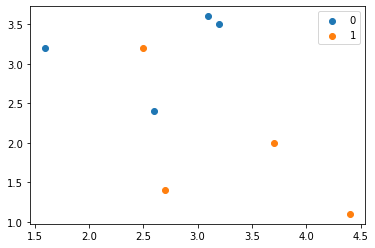

In [4]:
n = 4 # Sample size from each class
dim = 2
data = np.zeros((2 * n, dim))
mean1, cov1 = [2, 4], (1/2) * np.identity(dim)
mean2, cov2 = [4,2], (1/2) * np.identity(dim)
np.random.seed(1)
data[:n] = np.random.multivariate_normal(mean1, cov1, n)
np.random.seed(2)
data[n:] = np.random.multivariate_normal(mean2, cov2, n)

data = np.around(data, 1) #Round data to 1 decimal
#np.random.multivariate_normal([2,4], np.identity(dim), 10)
plt.scatter(data[:n, 0], data[:n, 1], label = '0')
plt.scatter(data[n:, 0], data[n:, 1], label = '1')
plt.legend()
print(data)

y = np.zeros(2*n)
y[n:] = 1
print(y)

In [63]:
a = np.arange(10).reshape(5,2)
b = np.random.randint(5, size=10).reshape(5,2)
print(a, b, np.inner(a,b), sep="\n")

[[0 1]
 [2 3]
 [4 5]
 [6 7]
 [8 9]]
[[3 4]
 [2 4]
 [4 2]
 [4 3]
 [1 4]]
[[ 4  4  2  3  4]
 [18 16 14 17 14]
 [32 28 26 31 24]
 [46 40 38 45 34]
 [60 52 50 59 44]]


Calculate $$I[u] = \frac{1}{p} \sum_{i,j=1}^n | \nabla u(x_i,x_j) |^p + \sum_{j=1}^m(y_j - \bar{y}) \cdot u(x_j)$$
where $$ \nabla u(x_i, x_j) = u(x_j) - u(x_i) $$

In [55]:
# Calculates vector of degrees for the weight matrix W
# W: (n,k) numpy array
    
def degrees(W):
    return W.sum(axis = 1)

# Example
# Calculates degrees of equilateral triangle
# W = np.array([[0, 1, 1], [1,0,1], [1,1,0]])
# print(degrees(W))

"""
Computes the gradient of u
u: (n,k) matrix
"""
def grad(u, W):
    n = u.shape[0]
    k = u.shape[1]
    gradu = np.zeros((n,n,k))
    for i in range(n):
        for j in range(n):
            gradu[i][j] = u[j] - u[i]
    return gradu
            

"""
u_flattened: n*k matrix
y: (m,k) matrix
idx = vector of labelled indices
"""
def penergy(u_flattened, W, idx, y, p):
    k = y.shape[1]
    n = int(u_flattened.size/k)
    u = u_flattened.reshape((n,k))
    gradu = grad(u, W)
    y_bar = (1/y.shape[0]) * y.sum(axis = 0)
    
    first_summand = (1/p) * (np.apply_along_axis(np.linalg.norm, 2, gradu) ** p).sum()
    second_summand = np.sum( (y - y_bar) * u[idx] )
    
    return first_summand - second_summand

## Example
# u = np.array([[1,0], [0,1], [1/2, 1/2]])
# y = np.array([[1,0], [0,1]])
# W = np.array([[0, 1, 1], [1,0,1], [1,1,0]])
# idx = [0, 1]
# p = 2

# print(np.apply_along_axis(np.linalg.norm, 2, grad(u, W)))
# print(penergy(u, W, idx, y, 2))
# print(penergy(u, W, idx, y, 3))

In [64]:
y = np.array([[1,0], [0,1]])
W = np.array([[0, 1, 1], [1,0,1], [1,1,0]])
d = degrees(W)
idx = [0, 1]
n = 3
k = 2
p = 2

eye = np.eye(k)

constrain_matrix = np.concatenate([d[i] * eye for i in range(n)], axis = 1)
# print(constrain_matrix)
linear_constraint = LinearConstraint(constrain_matrix, np.zeros(k), np.zeros(k))
res = minimize(penergy, x0 = np.ones(n * k), args = (W, idx, y, p), method = 'trust-constr', constraints = linear_constraint)
sol = res.x.reshape(n,k)
# print("Minimizer:\n", sol)
# print("Energy of minimizer:", penergy(res.x, W, idx, y, p))
print(2*u[0]-u[1]-u[2])
print(2*u[1]-u[0]-u[2])
print(2*u[2]-u[0]-u[1])

[ 1.5 -1.5]
[-1.5  1.5]
[0. 0.]


10
Accuracy: 100.00%


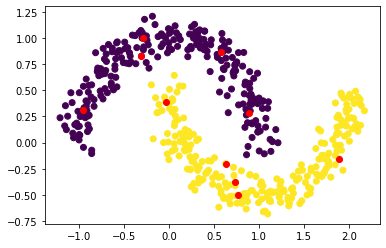

In [31]:
X,labels = datasets.make_moons(n_samples=500,noise=0.1)
W = gl.weightmatrix.knn(X,10,symmetrize=False)

train_ind = gl.trainsets.generate(labels, rate=5)
print(train_ind.size)
train_labels = labels[train_ind]

model = gl.ssl.poisson(W, solver='gradient_descent')
pred_labels = model.fit_predict(train_ind, train_labels)

accuracy = gl.ssl.ssl_accuracy(pred_labels, labels, len(train_ind))   
print("Accuracy: %.2f%%"%accuracy)

plt.scatter(X[:,0],X[:,1], c=pred_labels)
plt.scatter(X[train_ind,0],X[train_ind,1], c='r')
plt.show()

In [47]:
# Toy example
y = np.array([[1,0], [0,1]])
W = np.array([[0, 1, 1], [1,0,1], [1,1,0]])
d = degrees(W)
idx = [0, 1]
n = 3
k = 2
p = 2

model = gl.ssl.poisson(W)
u = model.fit(idx, np.array([0, 1]))
# print(2*u[0]-u[1]-u[2])
# print(2*u[1]-u[0]-u[2])
# print(2*u[2]-u[0]-u[1])
# print(u[0] + u[1] + u[2])
print(u)

[ 0.5 -0.5]
[-0.5  0.5]
[0. 0.]
[0. 0.]
[[ 0.16666667 -0.16666667]
 [-0.16666667  0.16666667]
 [ 0.          0.        ]]
